(discrete_choice)=
# Discrete Choice and Random Utility Models

:::{post} June, 2023
:tags: categorical regression, generalized linear model, discrete choice 
:category: advance, reference
:author: Nathaniel Forde
:::

In [1]:
import arviz as az
import numpy as np  # For vectorized math operations
import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt

from matplotlib import pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Discrete Choice Modelling: The Idea

Discrete choice modelling is related to the idea of a latent utility scale as discussed in {ref}`ordinal_regression`, but it kind of generalises the idea. It posits that we model human decision making as a function of latent utility measurements over a set of mutually exclusive alternative options. The theory is that any decision maker will go with the option that maximises their subjective utility, and that utility can be modelled as a latent linear function of observable features of the world. 

The idea is perhaps most famously applied by Daniel McFadden in the 1970s to predict the market share of California after the proposed introduction of BART light rail system. It's worth pausing on that point. The theory is one of micro level human decision making, that has in real applications been scaled up to make broadly accurate societal level predictions. For more details we recommend {cite:t}`train2009`

Don't be too credulous either, this is just a statistical model and success here is entirely dependent on the skill of modeller and the available measurements coupled with plausible theory. But it's worth just noting the scale of the ambition underlying these models. 

### The Heating Data

In this example, we'll examine the technique of discrete choice modelling using a (i) heating system data set from the R `mlogit` package and (ii) repeat choice data set over cracker. However we'll be pursuing a Bayesian approach to estimating the models rather than the MLE methodology reported in their vigenette. The first data set shows household choices over offere of heating systems in California.  The observations consist of single-family houses in California that were newly built and had central air-conditioning. Five types of systems are considered to have been possible:

 - gas central (gc),
 - gas room (gr),
 - electric central (ec),
 - electric room (er),
 - heat pump (hp).

The data set reports the installation `ic.alt` and operating costs `oc.alt` each household was faced with for each of the five alternatives with some broad demographic information about the household and crucially the choice `depvar`. This is what one choice scenario over the five alternative looks like in the data.


In [3]:
wide_heating_df = pd.read_csv("../data/heating_data_r.csv")
wide_heating_df[wide_heating_df["idcase"] == 1]

,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,oc.ec,oc.er,oc.hp,income,agehed,rooms,region
0,1,gc,866.0,962.64,859.9,995.76,1135.5,199.69,151.72,553.34,505.6,237.88,7,25,6,ncostl


The core idea of these kinds of models is to conceive of this as a choice over exhaustive options with attached latent utility. The utility ascribed to each option is viewed as a linear combination of the attributes for each option, which drives the probability of choosing amongst each option. For each $j$ in all the alternatives $Alt$ which is assumed to take a Gumbel distribution. 

$$ \mathbf{U} \sim Gumbel $$

$$ \begin{pmatrix}
u_{gc}   \\
u_{gr}   \\
u_{ec}   \\
u_{gr}   \\
u_{hp}   \\
\end{pmatrix} =  \begin{pmatrix}
gc_{ic} & gc_{oc}  \\
gr_{ic} & gr_{oc}  \\
ec_{ic} & ec_{oc}  \\
gr_{ic} & gr_{oc}  \\
hp_{ic} & hp_{oc}  \\
\end{pmatrix} \begin{pmatrix}
\beta_{ic}   \\
\beta_{oc}   \\
\end{pmatrix}  $$

This assumption proves to be mathematically convenient because the difference between two Gumbel distributions can be modelled as a logistic function, meaning we can model a contrast difference among multiple alternatives with the softmax function: 

$$ \text{softmax}(u)_{j} = \frac{\exp(u_{j})}{\sum_{q=1}^{J}\exp(u_{q})} $$

The model then assumes that decision maker chooses the option that maximises their subjective utility, the individual utility functions can be richly parameterised. The model is identified just when the utility measures of the alternatives are benchmarked against the fixed utility of the "outside good." The last quantity is fixed at 0. 

$$\begin{pmatrix}
u_{gc}   \\
u_{gr}   \\
u_{ec}   \\
u_{gr}   \\
0   \\
\end{pmatrix}
$$

With these constraints applied we can build out conditional random utility model and it's hierarchical variants. Like nearly all subjects in statistics the precise vocabulary for the model specification is overloaded. The conditional logit parameters $\beta$
may be fixed at the level of the individual, but can vary across individuals too. 

### Digression on Data Formats

Discrete choice models are often estimated using a long-data format where each choice scenario is represented with a row per alternative ID and a binary flag denoting the chosen option in each scenario. This data format is recommended for estimating these kinds of models in `stan` and in `pylogit`. The reason for doing this is that once the columns `installation_costs` and `operating_costs` have been pivoted in this fashion it's easier to include them in matrix calculations. 



In [4]:
long_heating_df = pd.read_csv("../data/long_heating_data.csv")
long_heating_df[long_heating_df["idcase"] == 1]

,Unnamed: 0,idcase,alt_id,choice,depvar,income,agehed,rooms,region,installation_costs,operating_costs
0,0,1,1,1,gc,7,25,6,ncostl,866.00,199.69
1,1,1,2,0,gc,7,25,6,ncostl,962.64,151.72
2,2,1,3,0,gc,7,25,6,ncostl,859.90,553.34
3,3,1,4,0,gc,7,25,6,ncostl,995.76,505.60
4,4,1,5,0,gc,7,25,6,ncostl,1135.50,237.88


## The Basic Model

We will show here how to incorporate the random utility specifications in PyMC. 

Sampling: [beta_ic, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.324455
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.331323
Transforming variables...
Transformation time =  0:00:00.425017
Computing Log Likelihood...


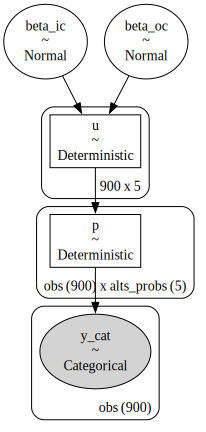

In [5]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes
coords = {
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}

with pm.Model(coords=coords) as model_1:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)

    ## Construct Utility matrix and Pivot
    u0 = beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=101)
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model_1)

In [6]:
idata_m1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [7]:
summaries = az.summary(idata_m1, var_names=["beta_ic", "beta_oc"])
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.002,0.0,0.002,0.002,0.0,0.0,1870.0,1999.0,1.0
beta_oc,-0.004,0.0,-0.005,-0.004,0.0,0.0,881.0,1105.0,1.0


In the `mlogit` vignette they report how the above model specification leads to inadequate parameter estimates. They note for instance that while the utility scale itself is hard to interpret the value of the ratio of the coefficients is often meaningful because when:

$$ U = \beta_{oc}oc + \beta_{ic}ic $$

then

$$ dU = \beta_{ic} dic + \beta_{oc} doc = 0 \Rightarrow 
-\frac{dic}{doc}\mid_{dU=0}=\frac{\beta_{oc}}{\beta_{ic}}$$

Our parameter estimates differ from the reported estimates, but we agree the model is inadequate. We will show a number of Bayesian model checks to demonstrate this fact, but the main call out is that the parameter values ought to be negative. To interpret the beta coefficient as the increase in utility as a function of a one unit increase in terms of price, so it's strange that an increase in price would increase the utility of generated by the installation even marginally as here. Although we might imagine that some kind of quality assurance comes with price which drives satisfaction with higher installation costs. The coefficient for repeat operating costs is negative as expected. Below we'll see how we can incorporate prior knowledge to adjust for this kind of interpretation. 

We can calculate the marginal rate of substitution as follows:


In [8]:
## marginal rate of substitution for a reduction in installation costs
summaries["mean"]["beta_oc"] / summaries["mean"]["beta_ic"]

-2.0

But being good Bayesians we actually want to calculate the posterior distribution for this statistic.

Text(0.5, 1.0, 'Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs')

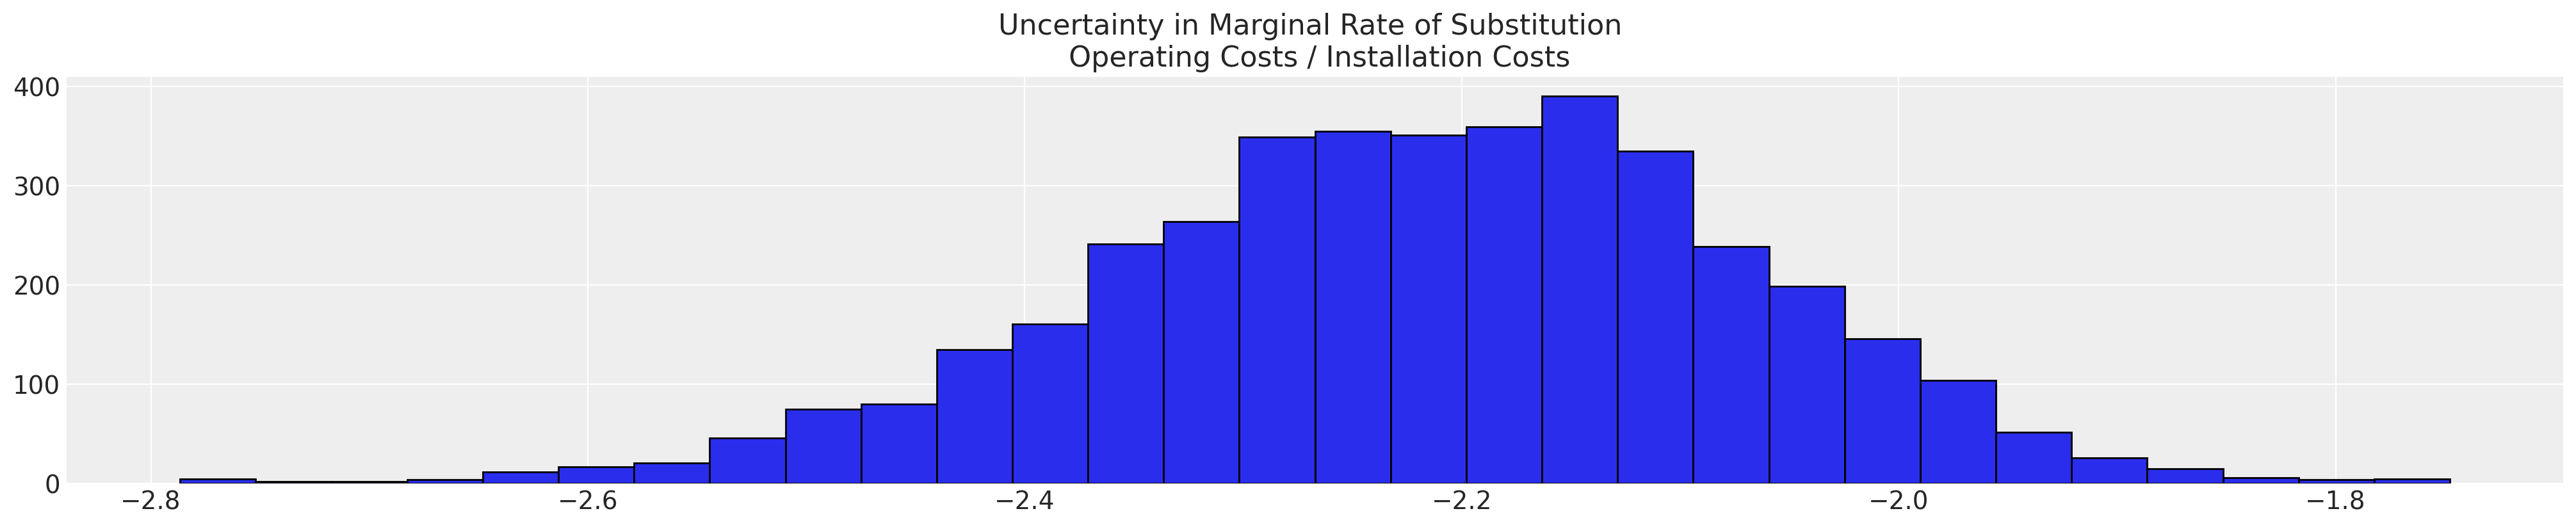

In [9]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.hist(
    az.extract(idata_m1["posterior"]["beta_oc"] / idata_m1["posterior"]["beta_ic"])["x"],
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs")

which suggests that there is almost twice the value accorded to the a unit reduction in recurring operating costs over the one-off installation costs. Whether this is remotely plausible is almost beside the point since the model does not even closely capture the data generating process. 

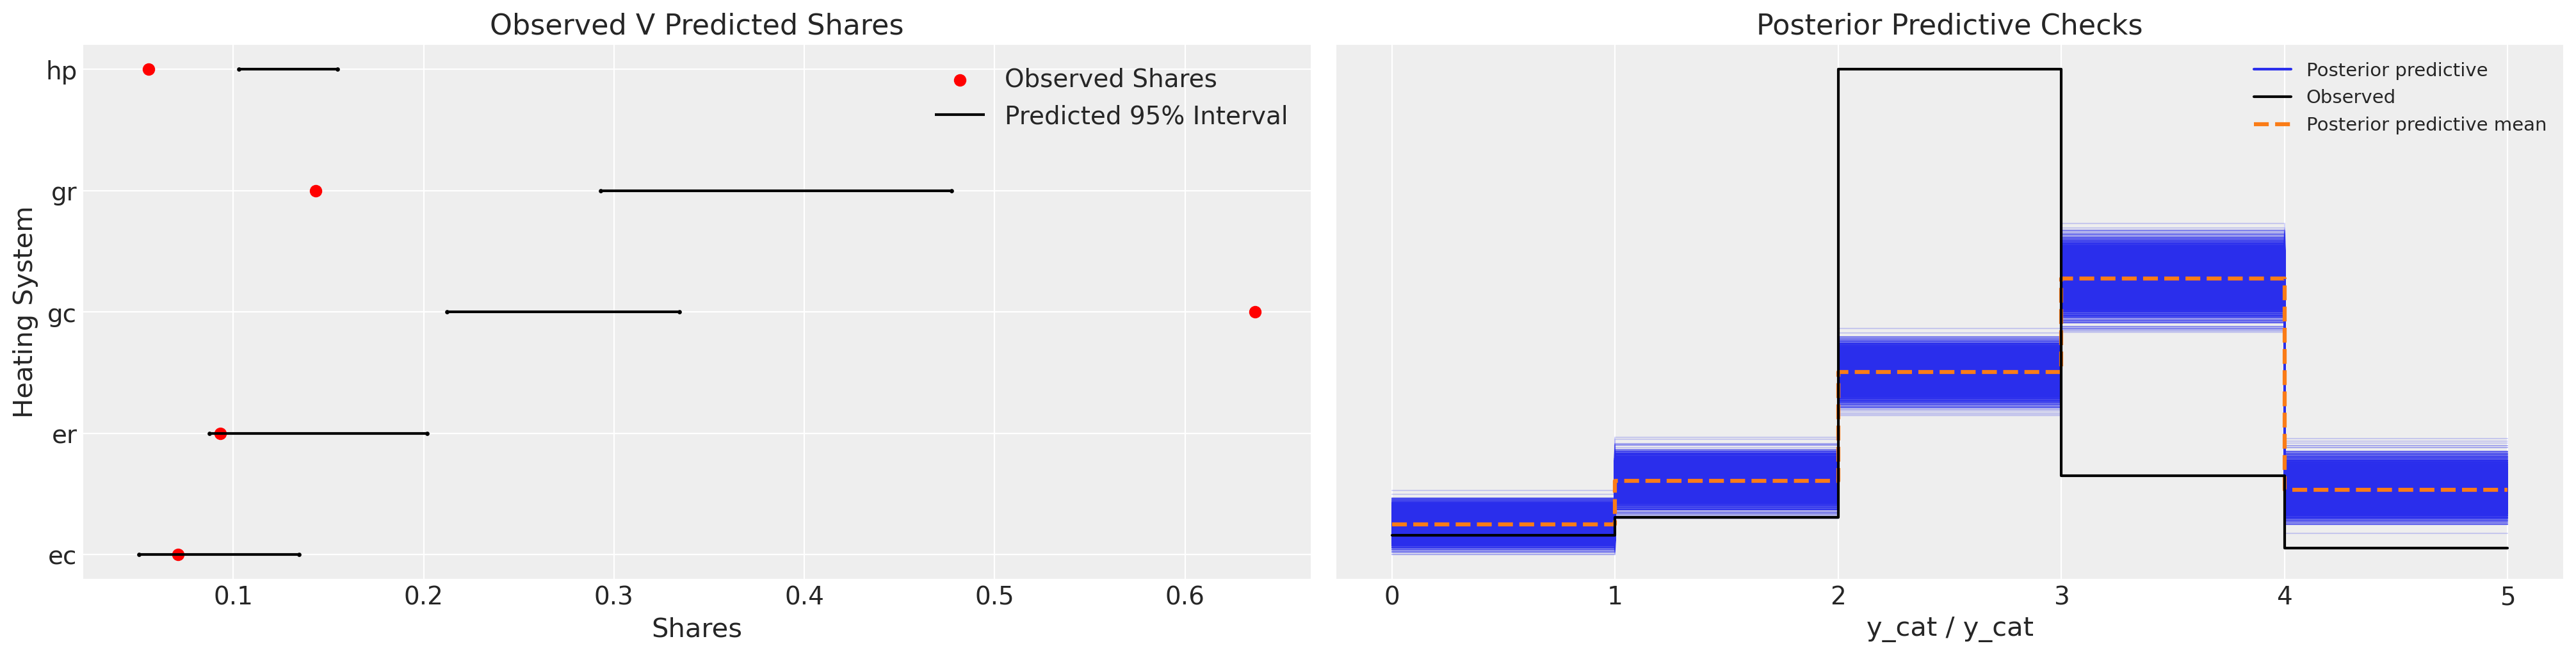

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = az.extract(idata_m1, var_names=["p"]).mean(axis=2).mean(axis=0)
ci_lb = np.quantile(az.extract(idata_m1, var_names=["p"]).mean(axis=2), 0.025, axis=0)
ci_ub = np.quantile(az.extract(idata_m1, var_names=["p"]).mean(axis=2), 0.975, axis=0)
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(), ["ec", "er", "gc", "gr", "hp"], label="Observed Shares", color="red"
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m1, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

We can see here that the model is fairly inadequate, and fails quite dramatically to recapture the posterior predictive distribution. 

## Improved Model: Adding Alternative Specific Intercepts

We can address some of the issues with the prior model specification by adding intercept terms for each of the unique alternatives `gr, gc, ec, er`. 

Sampling: [alpha, beta_ic, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.291818
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:12.511927
Transforming variables...
Transformation time =  0:00:00.272492
Computing Log Likelihood...


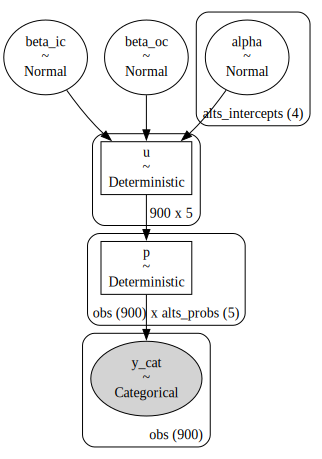

In [11]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes

coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_2:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")

    ## Construct Utility matrix and Pivot using an intercept per alternative
    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m2 = pm.sample_prior_predictive()
    idata_m2.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m2.extend(pm.sample_posterior_predictive(idata_m2))


pm.model_to_graphviz(model_2)

In [12]:
az.summary(idata_m2, var_names=["beta_ic", "beta_oc", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.001,0.000,-0.000,0.001,0.000,0.000,1215.0,1612.0,1.00
beta_oc,-0.003,0.001,-0.005,-0.001,0.000,0.000,1379.0,1743.0,1.00
alpha[ec],1.039,0.497,0.076,1.936,0.016,0.012,908.0,1054.0,1.00
alpha[er],1.077,0.474,0.216,1.988,0.016,0.012,839.0,991.0,1.00
alpha[gc],2.376,0.309,1.789,2.953,0.011,0.008,814.0,836.0,1.01
alpha[gr],0.733,0.373,-0.031,1.374,0.013,0.009,854.0,947.0,1.01


We can see now how this model performs much better in capturing aspects of the data generating process. 

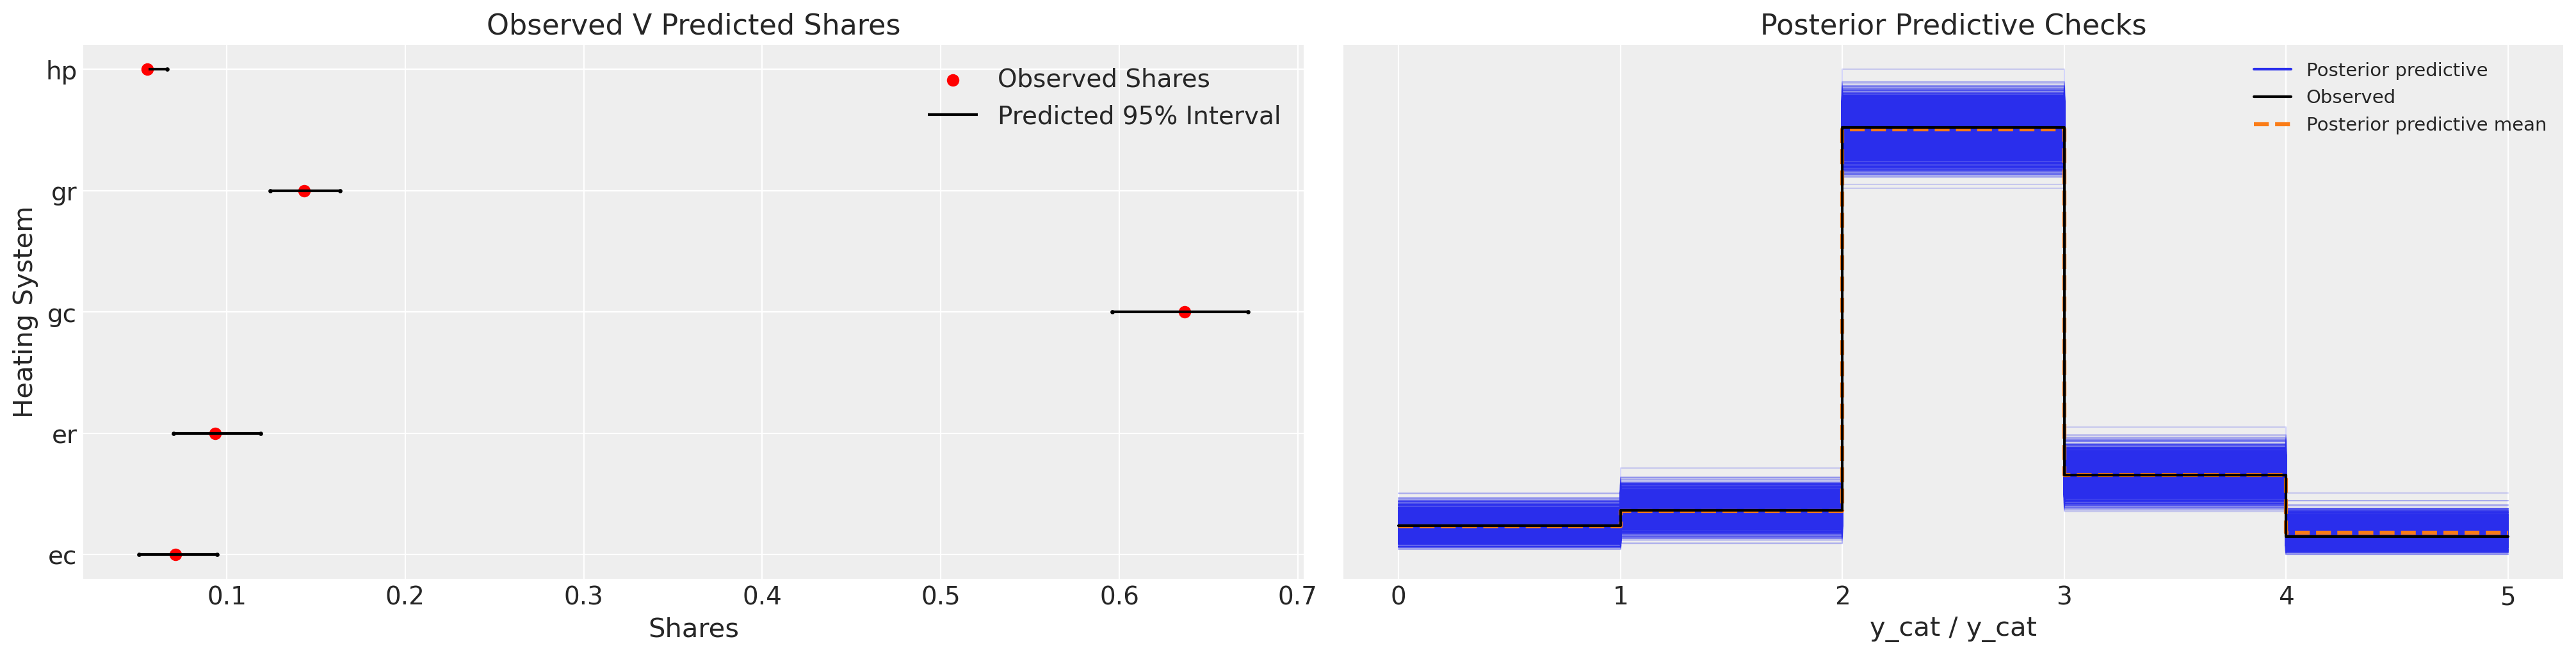

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = az.extract(idata_m2, var_names=["p"]).mean(axis=2).mean(axis=0)
ci_lb = np.quantile(az.extract(idata_m2, var_names=["p"]).mean(axis=2), 0.025, axis=0)
ci_ub = np.quantile(az.extract(idata_m2, var_names=["p"]).mean(axis=2), 0.975, axis=0)
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(), ["ec", "er", "gc", "gr", "hp"], label="Observed Shares", color="red"
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m2, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

This model represents a substantial improvement. It's worth pausing to consider how

## Experimental Model: Adding Correlation Structure

We might think that there is a correlation among the alternative goods that we should capture too. We can capture those effects in so far as they exist by placing a multvariate normal prior on the intercepts, (or alternatively the beta parameters). In addition we add information about how the effect of income influences the utility accorded to each alternative. 

Sampling: [alpha, beta_ic, beta_income, beta_oc, chol, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.182635
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:26.780070
Transforming variables...
Transformation time =  0:00:00.570896
Computing Log Likelihood...


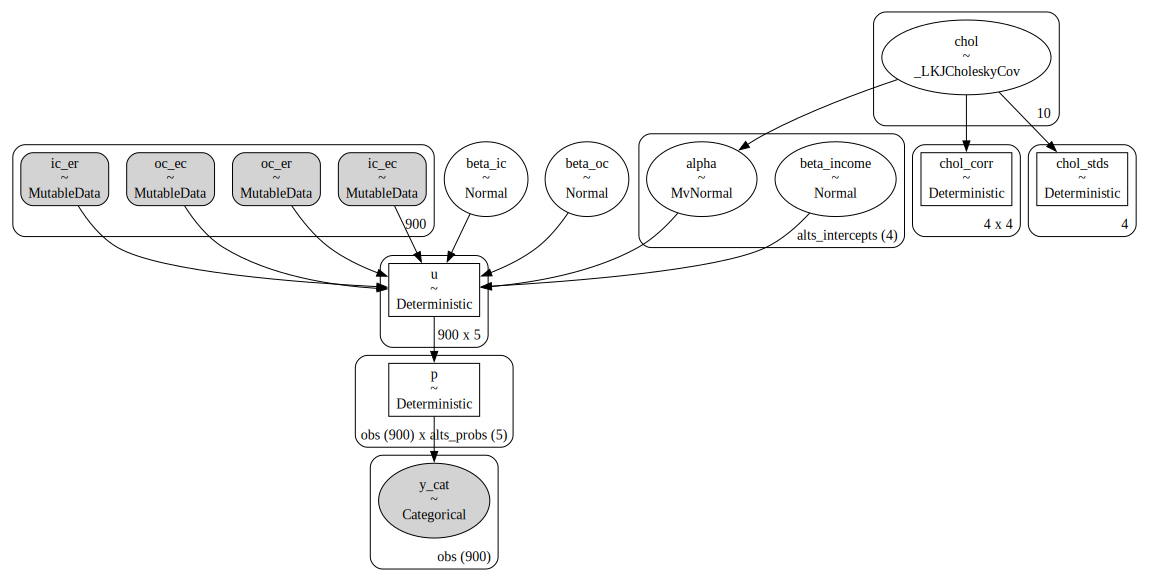

In [14]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_3:
    ## Add data to experiment with changes later.
    ic_ec = pm.MutableData("ic_ec", wide_heating_df["ic.ec"])
    oc_ec = pm.MutableData("oc_ec", wide_heating_df["oc.ec"])
    ic_er = pm.MutableData("ic_er", wide_heating_df["ic.er"])
    oc_er = pm.MutableData("oc_er", wide_heating_df["oc.er"])

    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=4, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    alphas = pm.MvNormal("alpha", mu=0, chol=chol, dims="alts_intercepts")

    u0 = alphas[0] + beta_ic * ic_ec + beta_oc * oc_ec + beta_income[0] * wide_heating_df["income"]
    u1 = alphas[1] + beta_ic * ic_er + beta_oc * oc_er + beta_income[1] * wide_heating_df["income"]
    u2 = (
        alphas[2]
        + beta_ic * wide_heating_df["ic.gc"]
        + beta_oc * wide_heating_df["oc.gc"]
        + beta_income[2] * wide_heating_df["income"]
    )
    u3 = (
        alphas[3]
        + beta_ic * wide_heating_df["ic.gr"]
        + beta_oc * wide_heating_df["oc.gr"]
        + beta_income[3] * wide_heating_df["income"]
    )
    u4 = np.zeros(N)  # pivot
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m3 = pm.sample_prior_predictive()
    idata_m3.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=100)
    )
    idata_m3.extend(pm.sample_posterior_predictive(idata_m3))


pm.model_to_graphviz(model_3)

Plotting the model fit we see a similar story.The model predictive performance is not drastically improved and we have added some complexity to the model.

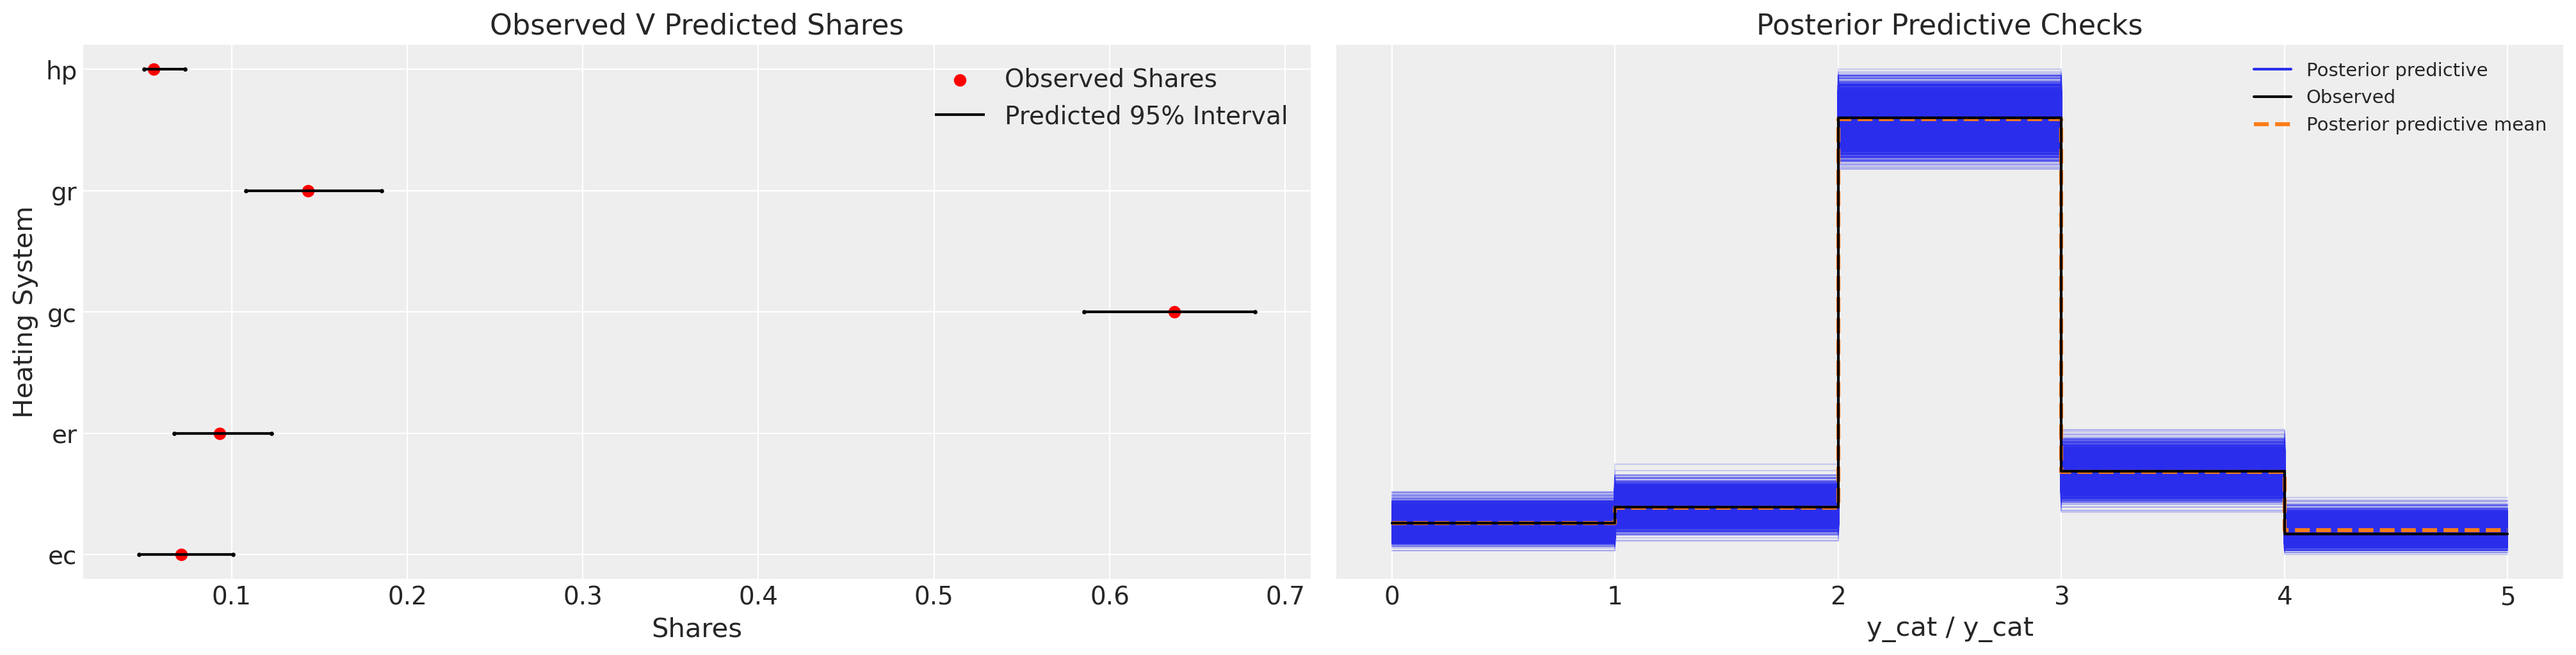

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = az.extract(idata_m3, var_names=["p"]).mean(axis=2).mean(axis=0)
ci_lb = np.quantile(az.extract(idata_m3, var_names=["p"]).mean(axis=2), 0.025, axis=0)
ci_ub = np.quantile(az.extract(idata_m3, var_names=["p"]).mean(axis=2), 0.975, axis=0)
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(), ["ec", "er", "gc", "gr", "hp"], label="Observed Shares", color="red"
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m3, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

However, that complexity can be informative, and the degree of relationship amongst the alternative products will inform the substitution patterns under policy changes.

In [16]:
az.summary(idata_m3, var_names=["beta_income", "beta_ic", "beta_oc", "alpha", "chol_corr"])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_income[ec],0.097,0.107,-0.102,0.305,0.004,0.002,936.0,1900.0,1.00
beta_income[er],0.066,0.105,-0.119,0.270,0.004,0.003,839.0,1614.0,1.00
beta_income[gc],0.067,0.087,-0.106,0.220,0.003,0.002,723.0,1321.0,1.00
beta_income[gr],-0.032,0.098,-0.222,0.144,0.003,0.002,808.0,1625.0,1.00
beta_ic,0.000,0.001,-0.001,0.002,0.000,0.000,753.0,914.0,1.00
beta_oc,-0.003,0.002,-0.006,-0.001,0.000,0.000,1436.0,2066.0,1.00
alpha[ec],1.035,1.048,-0.421,3.054,0.047,0.033,520.0,1178.0,1.01
alpha[er],1.239,1.075,-0.317,3.243,0.051,0.036,442.0,991.0,1.01
alpha[gc],2.372,0.761,1.122,3.771,0.037,0.026,415.0,699.0,1.01
alpha[gr],1.201,0.852,-0.095,2.801,0.040,0.028,442.0,1198.0,1.01


### Market Inteventions and Predicting Market Share

We can additionally use these kinds of models to predict market share under interventions where we change the price offering.

In [17]:
with model_3:
    # update values of predictors with new 20% price increase in operating costs for electrical options
    pm.set_data({"oc_ec": wide_heating_df["oc.ec"] * 1.2, "oc_er": wide_heating_df["oc.er"] * 1.2})
    # use the updated values and predict outcomes and probabilities:
    idata_new_policy = pm.sample_posterior_predictive(
        idata_m3,
        var_names=["p", "y_cat"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        random_seed=100,
    )

idata_new_policy

Inference data with groups:
	> predictions
	> predictions_constant_data

In [18]:
idata_new_policy["predictions"]["p"].stack({"sample": ["chain", "draw"]}).mean(axis=2).mean(axis=0)

<xarray.DataArray 'p' (alts_probs: 5)>
array([0.05383866, 0.07239016, 0.66253495, 0.1482966 , 0.06293963])
Coordinates:
  * alts_probs  (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp'

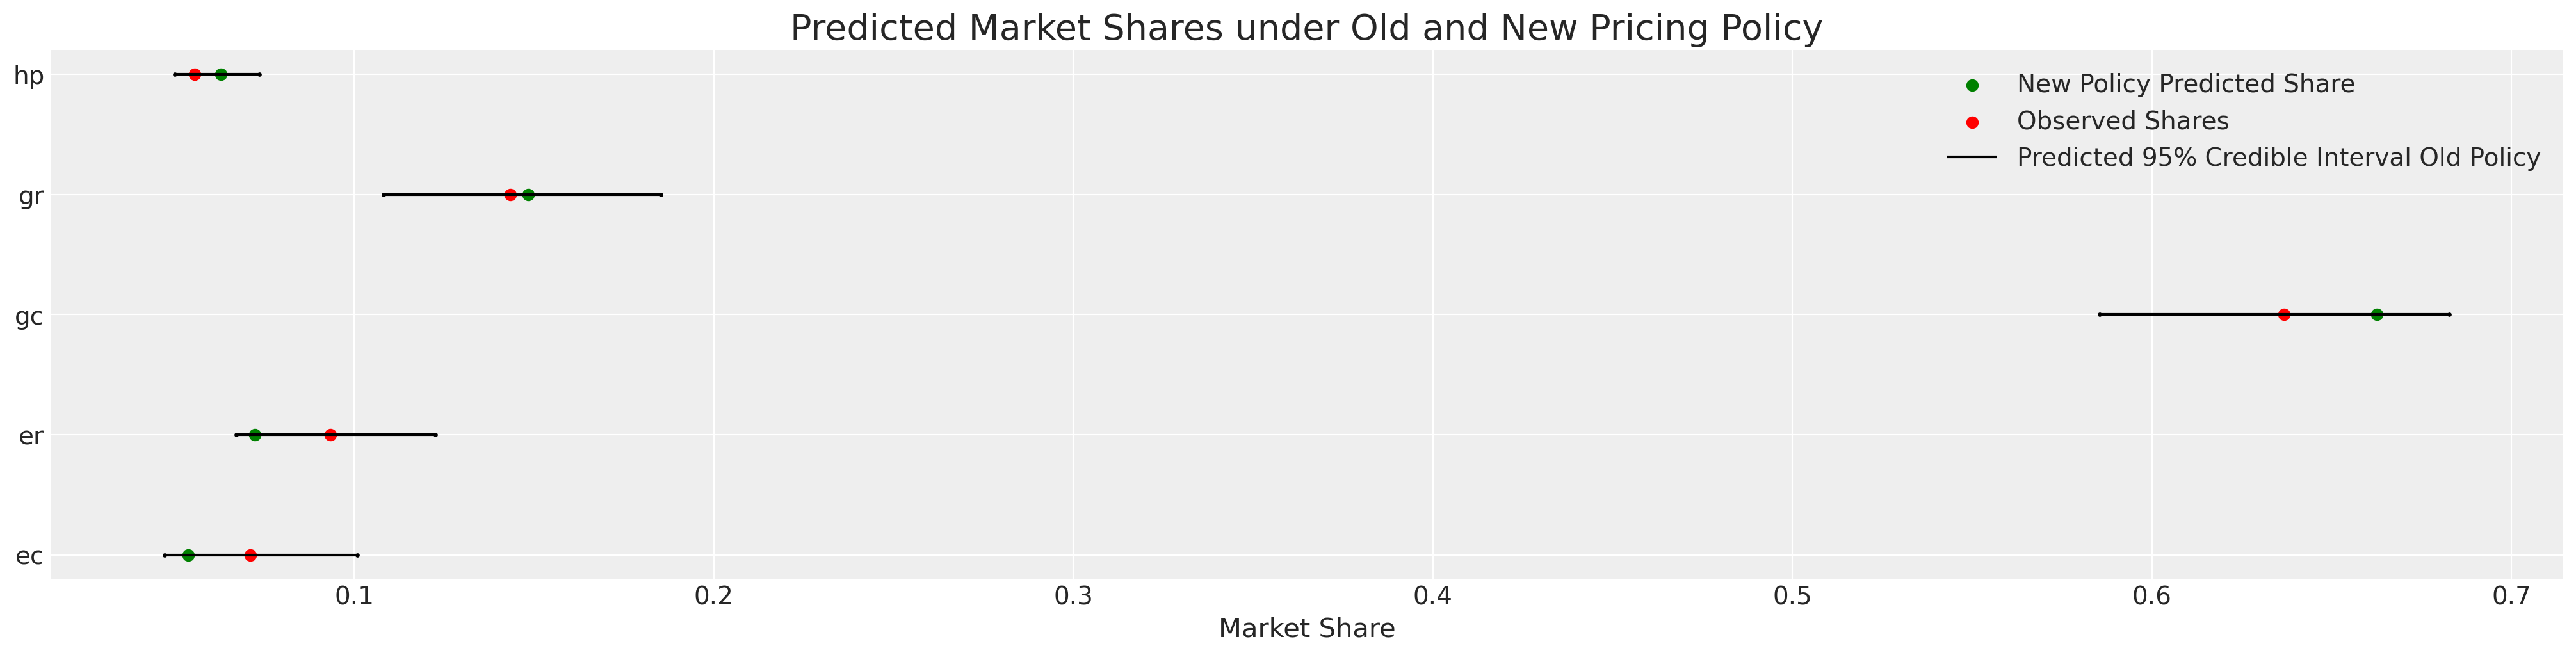

In [19]:
fig, ax = plt.subplots(1, figsize=(20, 5))
counts = wide_heating_df.groupby("depvar")["idcase"].count()
new_predictions = idata_new_policy["predictions"]["p"].stack({"sample": ["chain", "draw"]})
ci_lb = np.quantile(az.extract(idata_m3, var_names=["p"]).mean(axis=2), 0.025, axis=0)
ci_ub = np.quantile(az.extract(idata_m3, var_names=["p"]).mean(axis=2), 0.975, axis=0)
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    new_predictions.mean(axis=2).mean(axis=0).values,
    ["ec", "er", "gc", "gr", "hp"],
    color="green",
    label="New Policy Predicted Share",
)
ax.scatter(
    counts / counts.sum(), ["ec", "er", "gc", "gr", "hp"], label="Observed Shares", color="red"
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"],
    ci_lb,
    ci_ub,
    label="Predicted 95% Credible Interval Old Policy",
    color="black",
)
ax.set_title("Predicted Market Shares under Old and New Pricing Policy", fontsize=20)
ax.set_xlabel("Market Share")
ax.legend()

Here we can, as expected that a rise in the operating costs of the electrical options has a negative impact on their predicted market share. 

### Compare Models

We'll now evaluate all three model fits on their predictive performance. Predictive performance on the original data is a good benchmark that the model has appropriately captured the data generating process, but it is not the only feature of interest in these models. 

In [20]:
compare = az.compare({"m1": idata_m1, "m2": idata_m2, "m3": idata_m3})
compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m2,0,-1023.600913,4.964848,0.000000,1.000000e+00,27.802378,0.000000,False,log
m3,1,-1025.830915,9.954927,2.230002,1.110223e-16,28.086809,2.070977,False,log
m1,2,-1309.610756,1.196740,286.009843,1.110223e-16,12.933018,22.677610,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

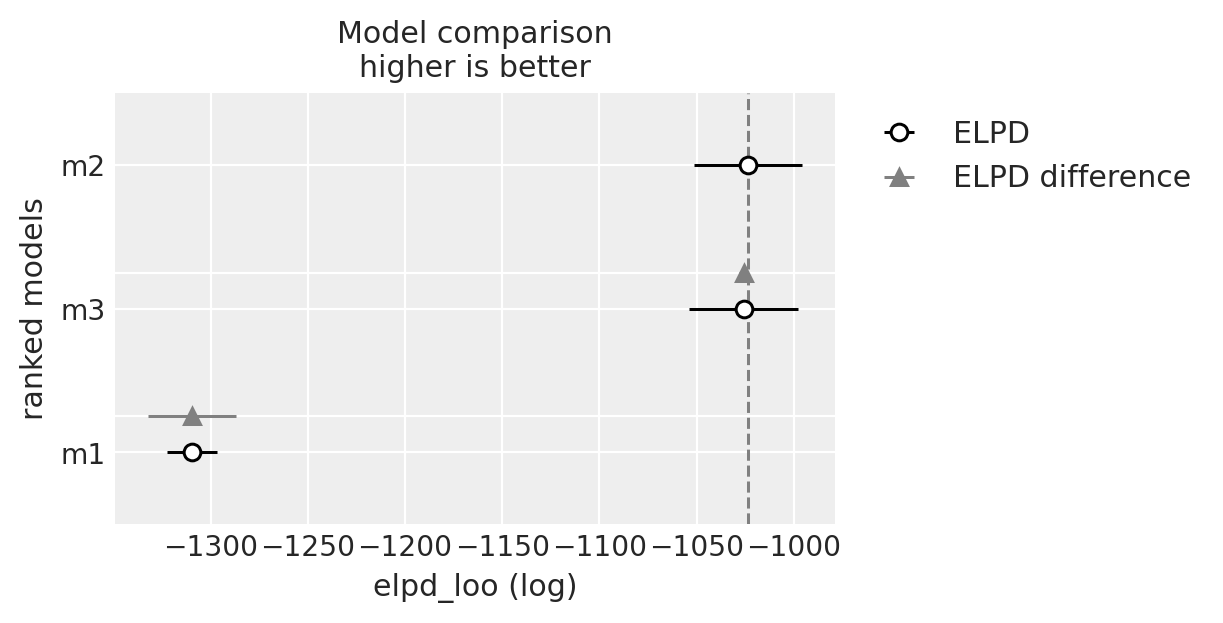

In [21]:
az.plot_compare(compare)

## Choosing Crackers over Repeated Choices: Mixed Logit Model

Moving to another example, we see a choice scenario where the same individual has been repeatedly polled on their choice of crackers among alternatives. This affords us the opportunity to evaluate the preferences of individuals by adding in coefficients for individuals for each product. 

In [22]:
c_df = pd.read_csv("../data/cracker_choice_short.csv")
## Focus on smaller subset of the decision makers. Need to use scan for full data set due bracket nesting level error
c_df = c_df[c_df["personId"] < 50]
c_df

,Unnamed: 0,personId,disp.sunshine,disp.keebler,disp.nabisco,disp.private,feat.sunshine,feat.keebler,feat.nabisco,feat.private,price.sunshine,price.keebler,price.nabisco,price.private,choice,lastChoice,personChoiceId,choiceId
0,1,1,0,0,0,0,0,0,0,0,0.99,1.09,0.99,0.71,nabisco,nabisco,1,1
1,2,1,1,0,0,0,0,0,0,0,0.49,1.09,1.09,0.78,sunshine,nabisco,2,2
2,3,1,0,0,0,0,0,0,0,0,1.03,1.09,0.89,0.78,nabisco,sunshine,3,3
3,4,1,0,0,0,0,0,0,0,0,1.09,1.09,1.19,0.64,nabisco,nabisco,4,4
4,5,1,0,0,0,0,0,0,0,0,0.89,1.09,1.19,0.84,nabisco,nabisco,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,1132,49,0,0,1,0,0,0,0,0,0.95,1.25,0.99,0.89,private,sunshine,35,1132
1132,1133,49,0,0,0,1,0,0,0,0,0.93,1.12,0.98,0.68,nabisco,private,36,1133
1133,1134,49,0,0,0,1,0,0,0,0,1.09,1.22,1.29,0.79,private,nabisco,37,1134
1134,1135,49,0,0,1,0,0,0,0,0,1.24,1.05,0.98,0.38,private,private,38,1135


In [23]:
c_df.groupby("personId")[["choiceId"]].count().T

personId,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
choiceId,15,15,13,28,13,27,16,25,18,40,...,21,25,19,13,22,27,16,31,16,39


Sampling: [alpha, beta_disp, beta_feat, beta_individual, beta_price, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:28.663481
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:19.292991
Transforming variables...
Transformation time =  0:00:08.068909
Computing Log Likelihood...


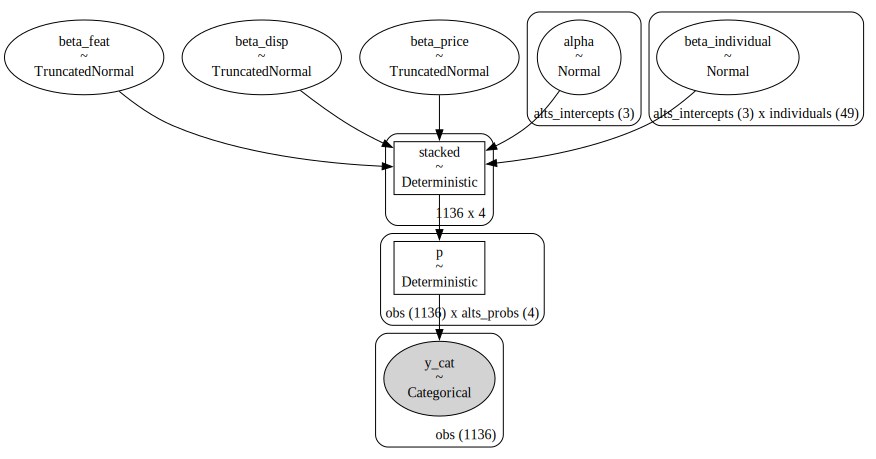

In [24]:
N = c_df.shape[0]
observed = pd.Categorical(c_df["choice"]).codes
uniques = c_df["personId"].unique()
coords = {
    "alts_intercepts": ["sunshine", "keebler", "nabisco"],
    "alts_probs": ["sunshine", "keebler", "nabisco", "private"],
    "individuals": uniques,
    "obs": range(N),
}
with pm.Model(coords=coords) as model_4:
    beta_feat = pm.TruncatedNormal("beta_feat", 0, 1, upper=10, lower=0)
    beta_disp = pm.TruncatedNormal("beta_disp", 0, 1, upper=10, lower=0)
    ## Stronger Prior on Price to ensure an increase in price negatively impacts utility
    beta_price = pm.TruncatedNormal("beta_price", 0, 1, upper=0, lower=-10)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")
    beta_individual = pm.Normal("beta_individual", 0, 0.05, dims=("alts_intercepts", "individuals"))

    ## Loop through each person's choice scenarios
    person_choice_scenario = []
    for id, indx in zip(uniques, range(len(uniques))):
        ## Construct Utility matrix and Pivot using an intercept per alternative
        n = c_df[c_df["personId"] == id].shape[0]
        u0 = (
            (alphas[0] + beta_individual[0, indx])
            + beta_disp * c_df[c_df["personId"] == id]["disp.sunshine"]
            + beta_feat * c_df[c_df["personId"] == id]["feat.sunshine"]
            + beta_price * c_df[c_df["personId"] == id]["price.sunshine"]
        )
        u1 = (
            (alphas[1] + beta_individual[1, indx])
            + beta_disp * c_df[c_df["personId"] == id]["disp.keebler"]
            + beta_feat * c_df[c_df["personId"] == id]["feat.keebler"]
            + beta_price * c_df[c_df["personId"] == id]["price.keebler"]
        )
        u2 = (
            (alphas[2] + beta_individual[2, indx])
            + beta_disp * c_df[c_df["personId"] == id]["disp.nabisco"]
            + beta_feat * c_df[c_df["personId"] == id]["feat.nabisco"]
            + beta_price * c_df[c_df["personId"] == id]["price.nabisco"]
        )
        u3 = np.zeros(n)  # Outside Good
        s = pm.math.stack([u0, u1, u2, u3]).T
        person_choice_scenario.append(s)
    # Reconstruct the total data
    s = pm.Deterministic("stacked", pt.concatenate(person_choice_scenario))

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m4 = pm.sample_prior_predictive()
    idata_m4.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m4.extend(pm.sample_posterior_predictive(idata_m4))


pm.model_to_graphviz(model_4)

In [25]:
az.summary(idata_m4, var_names=["beta_disp", "beta_feat", "beta_price", "alpha", "beta_individual"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_disp,0.063,0.052,0.000,0.160,0.001,0.001,4754.0,2298.0,1.00
beta_feat,0.049,0.047,0.000,0.137,0.001,0.001,4229.0,2074.0,1.00
beta_price,-0.042,0.041,-0.120,-0.000,0.001,0.000,4134.0,2496.0,1.00
alpha[sunshine],0.082,0.172,-0.224,0.413,0.003,0.002,3086.0,3290.0,1.00
alpha[keebler],2.229,0.134,1.981,2.478,0.002,0.002,3065.0,2953.0,1.00
...,...,...,...,...,...,...,...,...,...
"beta_individual[nabisco, 45]",-0.023,0.050,-0.113,0.073,0.001,0.001,7665.0,2413.0,1.01
"beta_individual[nabisco, 46]",-0.013,0.049,-0.105,0.077,0.001,0.001,9140.0,3010.0,1.00
"beta_individual[nabisco, 47]",-0.023,0.050,-0.116,0.072,0.001,0.001,7713.0,2334.0,1.00
"beta_individual[nabisco, 48]",-0.014,0.050,-0.107,0.080,0.001,0.001,8886.0,2860.0,1.00


Note here that we have explicitly set a negative prior on price and recovered a parameter specification more in line with the basic theory of rational choice. The effect of price should have a negative impact on utility. The flexibility of priors here is key for incorporating theoretical knowledge about the process involved in choice.  

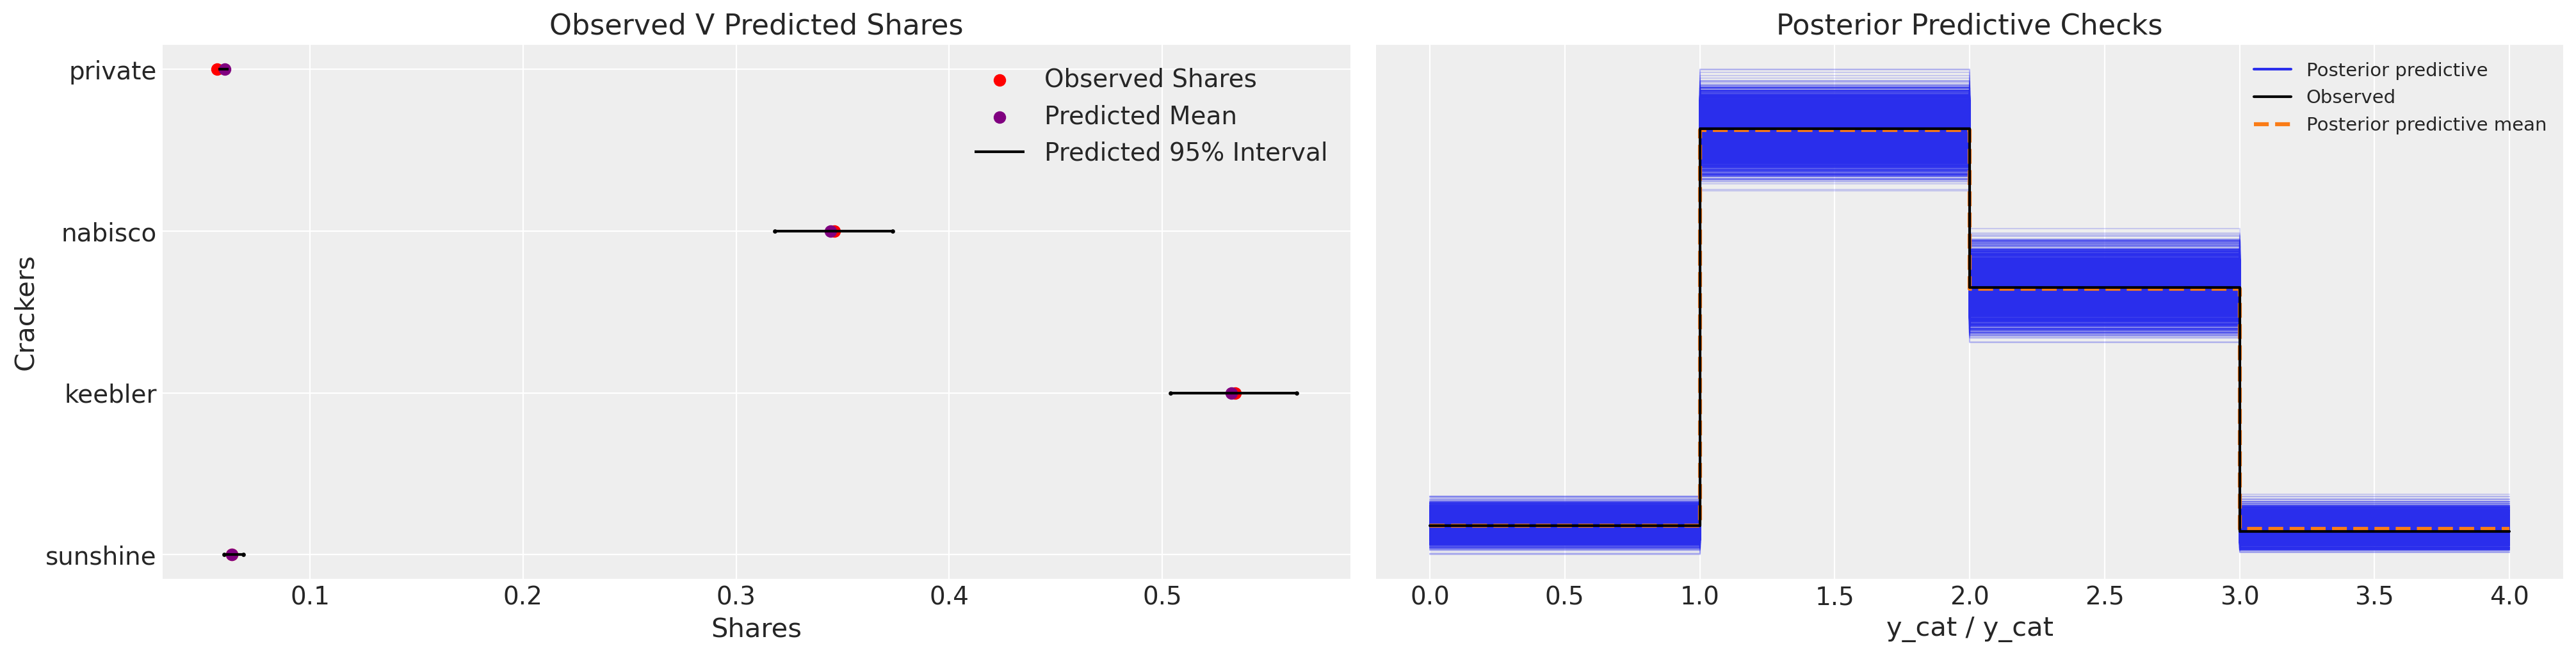

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax = axs[0]
counts = c_df.groupby("choice")["choiceId"].count()
predicted_shares = az.extract(idata_m4, var_names=["p"]).mean(axis=2).mean(axis=0)
ci_lb = np.quantile(az.extract(idata_m4, var_names=["p"]).mean(axis=2), 0.025, axis=0)
ci_ub = np.quantile(az.extract(idata_m4, var_names=["p"]).mean(axis=2), 0.975, axis=0)
mean = np.mean(az.extract(idata_m4, var_names=["p"]).mean(axis=2), axis=0)
ax.scatter(ci_lb, ["sunshine", "keebler", "nabisco", "private"], color="k", s=2)
ax.scatter(ci_ub, ["sunshine", "keebler", "nabisco", "private"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["sunshine", "keebler", "nabisco", "private"],
    label="Observed Shares",
    color="red",
)
ax.scatter(
    mean, ["sunshine", "keebler", "nabisco", "private"], label="Predicted Mean", color="purple"
)
ax.hlines(
    ["sunshine", "keebler", "nabisco", "private"],
    ci_lb,
    ci_ub,
    label="Predicted 95% Interval",
    color="black",
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m4, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Crackers");

We can now also recover the differences among individuals estimated by the model for particular cracker choices. 

In [27]:
idata_m4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

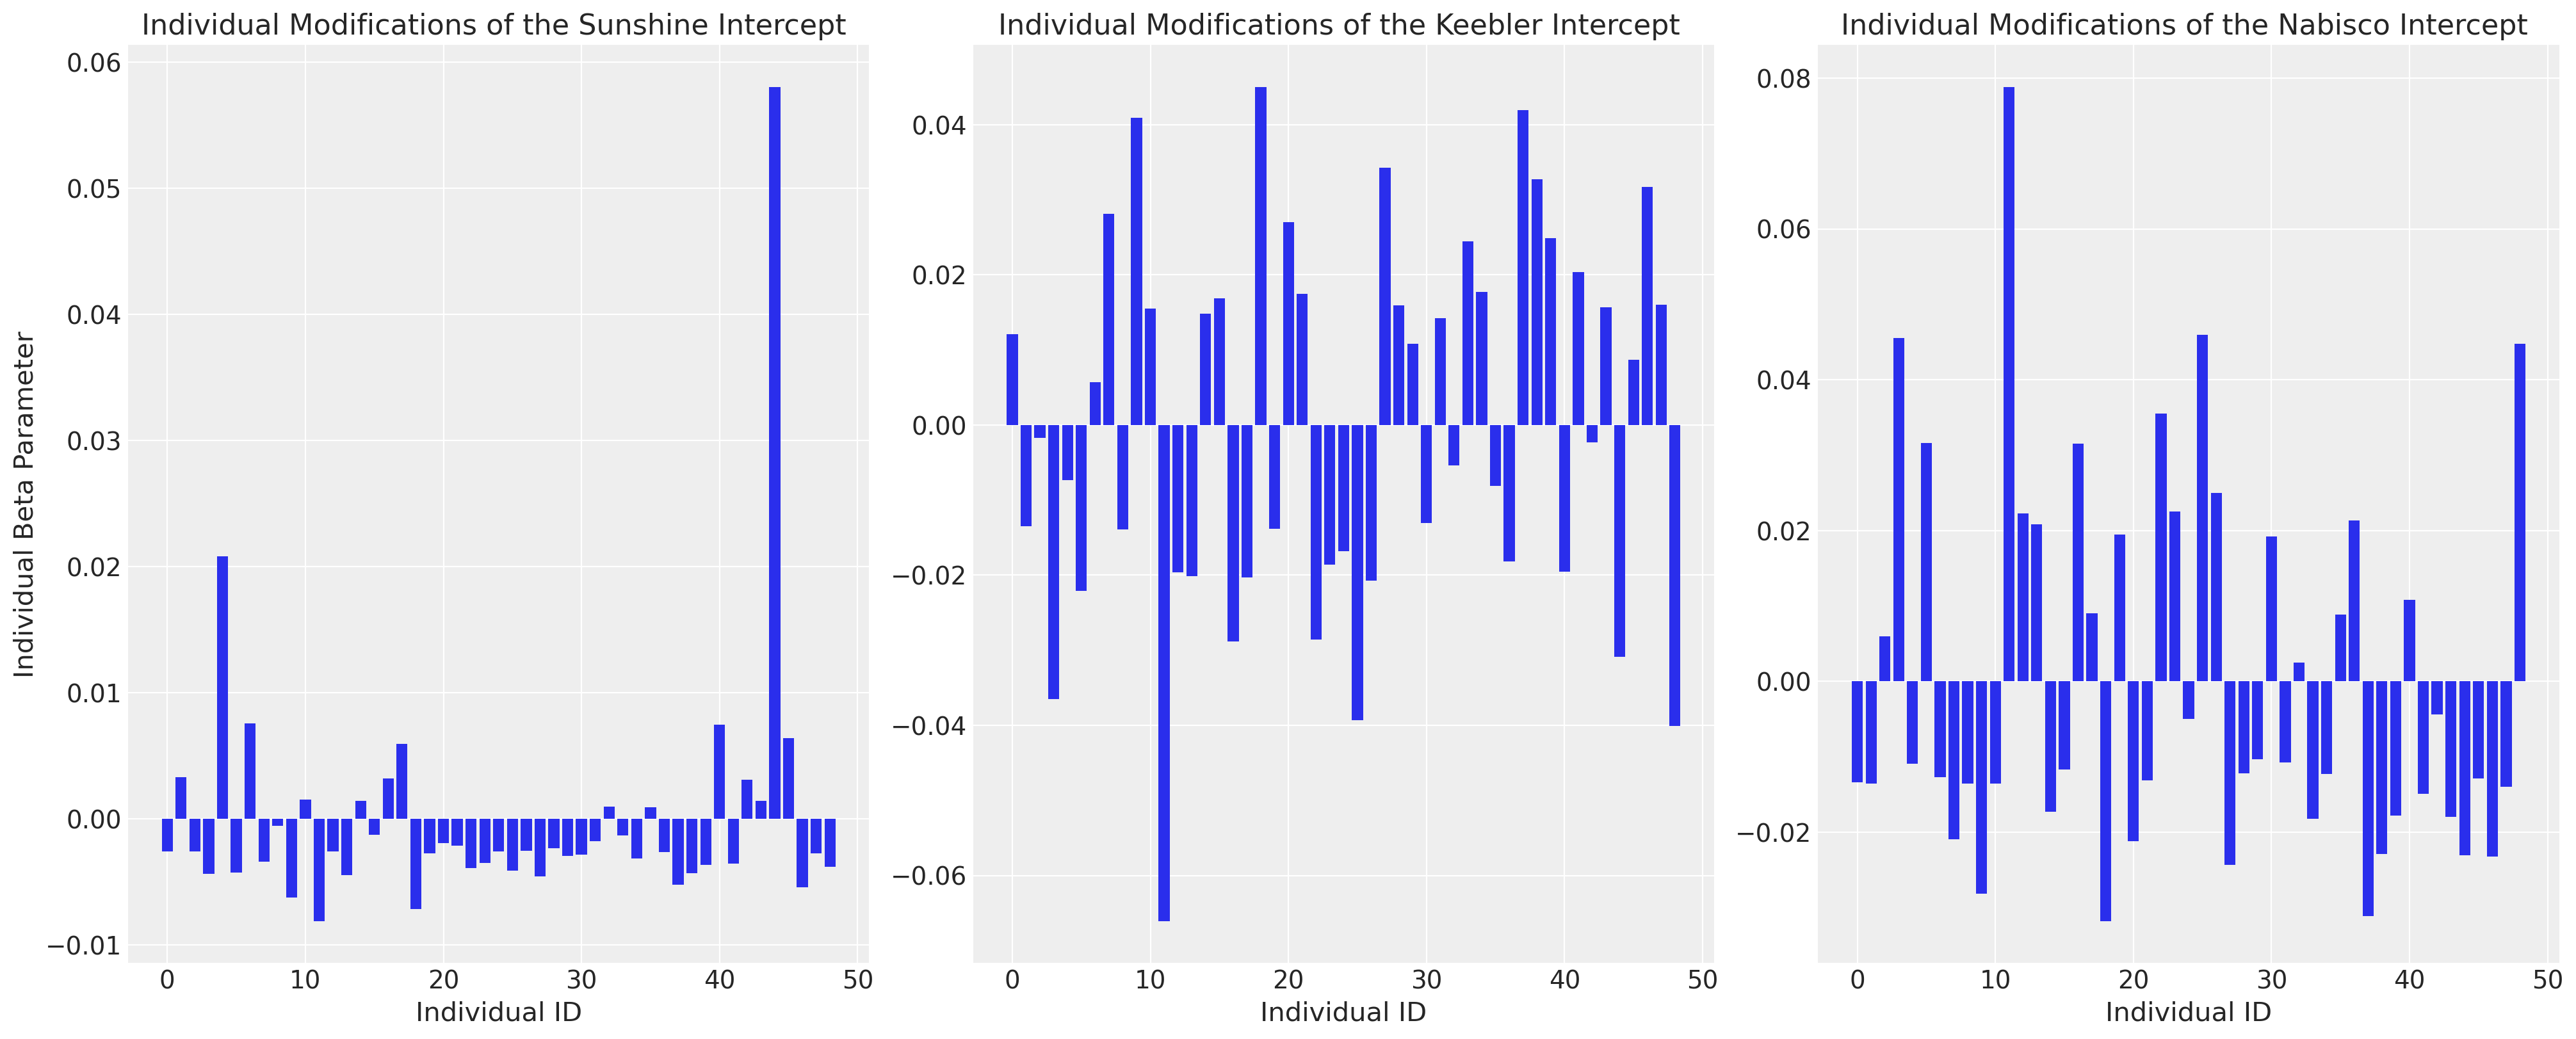

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = axs.flatten()
axs[0].bar(range(49), az.extract(idata_m4, var_names=["beta_individual"])[0, :, :].mean(axis=1))
axs[1].bar(range(49), az.extract(idata_m4, var_names=["beta_individual"])[1, :, :].mean(axis=1))
axs[2].bar(range(49), az.extract(idata_m4, var_names=["beta_individual"])[2, :, :].mean(axis=1))
axs[0].set_title("Individual Modifications of the Sunshine Intercept ")
axs[1].set_title("Individual Modifications of the Keebler Intercept ")
axs[2].set_title("Individual Modifications of the Nabisco Intercept ")
axs[1].set_xlabel("Individual ID")
axs[0].set_xlabel("Individual ID")
axs[2].set_xlabel("Individual ID")
axs[0].set_ylabel("Individual Beta Parameter");

## Conclusion

We can see here the flexibility and richly parameterised possibilities for modelling individual choice of discrete options. These techniques are useful in a wide variety of domains from microeconomics, to marketing and product development. The notions of utility, probability and their interaction lie at the heart of Savage's Representation theorem and justification(s) for Bayesian approaches to statistical inference. So discrete modelling is a natural fit for the Bayesian, but Bayesian statistics is also a natural fit for discrete choice modelling. The traditional estimation techniques are often brittle and very sensetive to starting values of the MLE process. The Bayesian setting trades this brittleness for a framework which allows us to incorporate our beliefs about what drives human utility calculations. We've only scratched the surface in this example notebook, but encourage you to further explore the technique. 



## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in June 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Jun 16 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

arviz     : 0.15.1
pymc      : 5.3.0
pytensor  : 2.11.1
numpy     : 1.23.5
matplotlib: 3.7.1
pandas    : 1.5.3

Watermark: 2.3.1



:::{include} ../page_footer.md
:::